# COMP 551 - Mini-project 3
Group 63

In [1]:
import keras
import numpy as np
%matplotlib inline                                 
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace  
import scipy.sparse as sparse
import pandas as pd
import seaborn as sns
import os

np.random.seed(1234)

## Task 1. Data pre-processing

- Load the raw data from Keras.
- Vectorize 28*28 pictures to 1D vector.
- Normalize the intensity of the pixel.

Load the MNIST dataset distributed with Keras. 

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


Vectorize the 28*28 pictures to a 784 vector.

In [3]:
x_train = np.reshape(x_train, (-1, 784)).astype('float32')
x_test = np.reshape(x_test, (-1, 784)).astype('float32')
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


The intensity ranges from 0 to 255. We divide all intensities by the maximum (255) to obtain a [0-1] range.

In [4]:
print('Intensity before normalization:', np.amin(x_train), np.amax(x_train))
x_train, x_test = x_train/255.0, x_test/255.0
print('Intensity after normalization:', np.amin(x_train), np.amax(x_train))

Intensity before normalization: 0.0 255.0
Intensity after normalization: 0.0 1.0


We transform the (N,) vector of labels using one-hot encoding into a (N,C) matrix.

In [5]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [6]:
print(y_train.shape, y_test.shape)
print(y_train[0:3,])

(60000, 10) (10000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## Task 2. Multilayer perceptron implementation

### 2.1 Build the network
Our task is a multiclass classification.The cost function will be the multi-class cross-entropy loss. We will use the following architecture:
- output layer = softmax activation
- hidden layers (0 or 1): 128 units, ReLu activation 


First, we implement the activation functions.

In [7]:
# softmax
eps=1e-8
def softmax(z):
    logits = z - np.max(z) # for numerical stability
    sum_logits = np.sum(np.exp(logits), axis=1) +eps
    softmax = np.exp(logits)/sum_logits[:,None] 
    return softmax

# relu
relu = lambda z: np.maximum(0,z)

# derivatives of relu (formula from backprop slides)
def relu_dv(q):
  q[q<=0] = 0
  q[q>0] = 1
  return q

Next, we build the MLP class.

In [8]:
 # for no hidden layer 
 class MLP_none:
    
    def __init__(self, cost=False):
        self.cost = cost
            
    def fit(self, x_train, y_train, x_test, y_test, optimizer):
        N = x_train.shape[0]
        C = y_train.shape[1] # number of classes
        D = x_train.shape[1]
        def gradient(x, y, w): 
            n = x.shape[0]
            # forward pass
            # add bias to the input layer 
            x = np.column_stack([x,np.ones(n)*0.1])
            yh = softmax(np.dot(x, w))#N x C
            # backward pass => gradient formula from class dw = (yh-y)*x
            dy = yh - y #N x C
            dw = np.dot(x.T, dy)/N #D x C
            return dw
        
        # initialize the parameters with values in the standard normal distribution and scaled to be low
        w = np.random.randn(D+1,C) * .01 #D x C
        if self.cost == True:
            self.params, self.train_loss, self.test_loss = optimizer.run(gradient, x_train, y_train, x_test, y_test, w)
        else:
            self.params = optimizer.run(gradient, x_train, y_train, x_test, y_test, w)
        return self
    
    def predict(self, x):
        w = self.params
        Nt = x.shape[0]
        x = np.column_stack([x,np.ones(Nt)*0.1])
        yh = softmax(np.dot(x, w))#N x C
        return yh

In [9]:
# for 1 hidden layer with relu activation
class MLP_relu_one:
    
    def __init__(self, M = 128, cost=False):
        self.M = M
        self.cost = cost
            
    def fit(self, x_train, y_train, x_test, y_test, optimizer):
        N = x_train.shape[0]
        C = y_train.shape[1] # number of classes
        D = x_train.shape[1]
        def gradient(x, y, params):
            v, w = params
            # forward pass
            n = x.shape[0]
            # add bias to the input layer
            x = np.column_stack([x,np.ones(n)*0.1])
            # add bias to the hidden layer
            b = np.ones((n,1))*0.1

            q = np.dot(x, v) 
            z = relu(np.hstack((q,b))) 
            yh = softmax(np.dot(z, w))
            dy = yh - y 
            dw = np.dot(z.T,dy)/N 
            dz = np.dot(dy,w.T)
            dz = np.delete(dz, -1, axis=1)
            dq = relu_dv(q)
            dv = np.dot(x.T, dz * dq)/N #M x C
            dparams = [dv, dw]
            return dparams
        
        # initialize the parameters with values in the standard normal distribution and scaled to be low
        w = np.random.randn(self.M+1,C) * .01 #M x M
        v = np.random.randn(D+1,self.M) * .01 #D x M
        
        params0 = [v,w]

        # run the mini-batch gradient descent to update the parameters
        if self.cost == True:
            self.params, self.train_loss, self.test_loss = optimizer.run(gradient, x_train, y_train, x_test, y_test, params0)
        else:
            self.params = optimizer.run(gradient, x_train, y_train, x_test, y_test, params0)
        return self
    
    def predict(self, x):
        v, w = self.params
        # add bias to the input layer
        Nt = x.shape[0]
        x = np.column_stack([x,np.ones(Nt)*0.1])
        # add bias to the hidden layer
        b1 = np.ones((Nt,1))*0.1
     
        # forward pass only using updated parameters

        q = np.dot(x,v)
        z = relu(np.hstack((q,b1)))
        yh = softmax(np.dot(z, w))#N x C
        return yh

### 2.2 Implement the cost and accuracy function



In [10]:
# Softmax cross entropy 
def logsumexp(Z):                                                # dimension N x C
    Zmax = np.max(Z,axis=1)[:,None]                              # max over C
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=1))
    return log_sum_exp

# cost for no hidden layer
def cost_none(x,y,v):
  Nt = x.shape[0]
  x = np.column_stack([x,np.ones(Nt)*0.1])
  u = np.dot(x, v) 
  nll = - np.mean(np.sum(u*y, 1) - logsumexp(u)) 
  return nll

# cost for relu activation - one layer
def cost_relu_one(x, y, params):
  Nt = x.shape[0]
  v, w = params
  b = np.ones((Nt,1))*0.1
  x = np.column_stack([x,np.ones(Nt)*0.1])
  q = np.dot(x, v) 
  z = relu(np.hstack((q,b)))
  u = np.dot(z, w) #N x C
  nll = - np.mean(np.sum(u*y, 1) - logsumexp(u)) 
  return nll

# Accuracy
def evaluate_acc(y, yh):
  y_pred = np.argmax(yh,axis=1)
  accuracy = np.count_nonzero(y_pred == np.argmax(y,axis=1))/y.shape[0]
  return accuracy

### 2.3. Implement the cross-validation function

In [11]:
def cross_validate(n, n_folds=6):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

### 2.4 Implement the optimizer

We will use a mini-batch gradient-descent algorithm.

In [12]:
def create_mini_batch(x, y, batch_size): 
    D = x.shape[1]
    data = np.hstack((x, y))
    np.random.shuffle(data)
    mini = data[:batch_size,:]                                                    
    x_mini = mini[:,:D]
    y_mini = mini[:,D:]
    return x_mini, y_mini

In [13]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, epsilon=1e-8, batch_size=100, iters=600, epochs=50, cost=False):
        self.learning_rate = learning_rate
        self.iters = iters
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.epochs = epochs
        self.cost = cost
        
    def run(self, gradient_fn, x_train, y_train, x_test, y_test, params):
      if self.cost == True:
        epoch = 1
        train_losses = []
        test_losses = []
        for epoch in range(self.epochs):
          train_epoch_loss = []
          test_epoch_loss = []
          for t in range(self.iters):
            x_mini, y_mini = create_mini_batch(x_train, y_train, self.batch_size)
            train_loss = cost_relu_one(x_mini, y_mini, params)
            test_loss = cost_relu_one(x_test, y_test, params)
            grad = gradient_fn(x_mini, y_mini, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            if t % self.iters == 0:
              print(f"Epoch: {epoch+1}, Train error: {train_loss:.4f}, Test error: {test_loss:.4f}")
              epoch += 1
            train_epoch_loss.append(train_loss)
            test_epoch_loss.append(test_loss)
          train_losses.append(np.mean(train_epoch_loss))
          test_losses.append(np.mean(test_epoch_loss))
        return params, train_losses, test_losses
      else:     
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t<self.iters:
            # create mini-batch
            x_mini, y_mini = create_mini_batch(x_train, y_train, self.batch_size)
            # calculate gradient for the mini-batch
            grad = gradient_fn(x_mini, y_mini, params)
            # update v and dw
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params


In [14]:
class GradientDescent_none:
    
    def __init__(self, learning_rate=.001, epsilon=1e-8, batch_size=100, iters=600, epochs=50, cost=False):
        self.learning_rate = learning_rate
        self.iters = iters
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.epochs = epochs
        self.cost = cost
        
    def run(self, gradient_fn, x_train, y_train, x_test, y_test, params):
        if self.cost == True:
            epoch = 1
            train_losses = []
            test_losses = []
            for epoch in range(self.epochs):
                    train_epoch_loss = []
                    test_epoch_loss = []
                    for t in range(self.iters):
                        x_mini, y_mini = create_mini_batch(x_train, y_train, self.batch_size)
                        train_loss = cost_none(x_mini, y_mini, params)
                        test_loss = cost_none(x_test, y_test, params)
                        grad = gradient_fn(x_mini, y_mini, params)
                        params -= self.learning_rate * grad
                        if t % self.iters == 0:
                          print(f"Epoch: {epoch+1}, Train error: {train_loss:.4f}, Test error: {test_loss:.4f}")
                          epoch += 1
                        train_epoch_loss.append(train_loss)
                        test_epoch_loss.append(test_loss)
                    train_losses.append(np.mean(train_epoch_loss))
                    test_losses.append(np.mean(test_epoch_loss))
            return params, train_losses, test_losses
        else:    
            norms = np.array([np.inf])
            t = 1
            while np.any(norms > self.epsilon) and t<self.iters:
            # create mini-batch
                x_mini, y_mini = create_mini_batch(x_train, y_train, self.batch_size)
            # calculate gradient for the mini-batch
                grad = gradient_fn(x_mini, y_mini, params)
            # update paramaters
                params -= self.learning_rate * grad
                t += 1
                norms = np.array([np.linalg.norm(g) for g in grad])
            return params


## Task 3. Run the experiments

### 3.1 Model without hidden layers.

Learning rate tuning with cross-validation.

In [15]:
learning_list = [0.1,1,10]

num_folds = 3
acc_valid = np.zeros((len(learning_list), num_folds))
for i, learning in enumerate(learning_list):
    #Find the validation accuracy for num_folds splits for a given learning rate
    for f, (tr, val) in enumerate(cross_validate(x_train.shape[0], num_folds)):
        model = MLP_none()
        optimizer = GradientDescent_none(learning_rate=learning, epochs=100, iters=20000, cost=False)
        model.fit(x_train[tr], y_train[tr], x_test, y_test, optimizer)
        acc_valid[i, f] = evaluate_acc(y_train[val], model.predict(x_train[val]))
        print('For learning rate =',learning,'and fold',f,'the accuracy is:',acc_valid[i, f])

For learning rate = 0.1 and fold 0 the accuracy is: 0.8362
For learning rate = 0.1 and fold 1 the accuracy is: 0.8359
For learning rate = 0.1 and fold 2 the accuracy is: 0.8466
For learning rate = 1 and fold 0 the accuracy is: 0.89225
For learning rate = 1 and fold 1 the accuracy is: 0.8862
For learning rate = 1 and fold 2 the accuracy is: 0.89445
For learning rate = 10 and fold 0 the accuracy is: 0.91445
For learning rate = 10 and fold 1 the accuracy is: 0.91165
For learning rate = 10 and fold 2 the accuracy is: 0.9143


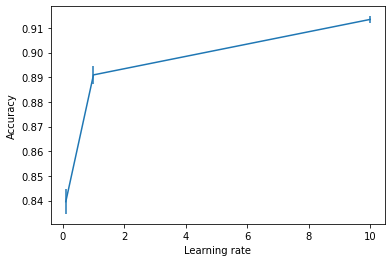

In [17]:
plt.errorbar(learning_list, np.mean(acc_valid, axis=1), np.std(acc_valid, axis=1))
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.show()

In [33]:
model = MLP_none()
optimizer = GradientDescent_none(learning_rate=10, epochs=100, iters=20000, cost=False)
model.fit(x_train, y_train, x_test, y_test, optimizer)
acc = evaluate_acc(y_test, model.predict(x_test))
print(f'The accuracy is {acc*100:.1f}.')

The accuracy is 91.9.


In [15]:
model = MLP_none(cost=True)
optimizer = GradientDescent_none(learning_rate=10, epochs=50, iters=600, cost=True)

model.fit(x_train, y_train, x_test, y_test, optimizer)

Epoch: 1, Train error: 2.3007, Test error: 2.3015
Epoch: 2, Train error: 0.6434, Test error: 0.5889
Epoch: 3, Train error: 0.5411, Test error: 0.4708
Epoch: 4, Train error: 0.4881, Test error: 0.4226
Epoch: 5, Train error: 0.4168, Test error: 0.3955
Epoch: 6, Train error: 0.3420, Test error: 0.3785
Epoch: 7, Train error: 0.4041, Test error: 0.3648
Epoch: 8, Train error: 0.2428, Test error: 0.3546
Epoch: 9, Train error: 0.3455, Test error: 0.3476
Epoch: 10, Train error: 0.3567, Test error: 0.3410
Epoch: 11, Train error: 0.2109, Test error: 0.3355
Epoch: 12, Train error: 0.3621, Test error: 0.3312
Epoch: 13, Train error: 0.2532, Test error: 0.3273
Epoch: 14, Train error: 0.2841, Test error: 0.3242
Epoch: 15, Train error: 0.3498, Test error: 0.3214
Epoch: 16, Train error: 0.3287, Test error: 0.3185
Epoch: 17, Train error: 0.3950, Test error: 0.3159
Epoch: 18, Train error: 0.3810, Test error: 0.3139
Epoch: 19, Train error: 0.3795, Test error: 0.3120
Epoch: 20, Train error: 0.3625, Test err

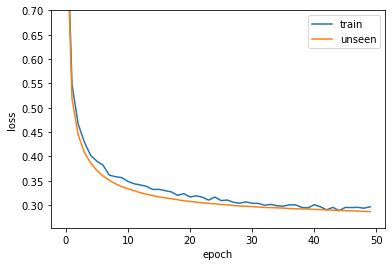

In [16]:
plt.plot(np.arange(len(model.train_loss)), model.train_loss, '-', label='train')
plt.plot(np.arange(len(model.test_loss)), model.test_loss, '-', label='unseen')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(top = 0.7)
plt.show()

### 3.2 Model with 1 hidden layer and ReLu activation.

Learning rate tuning with cross-validation.

In [ ]:
learning_list = [0.1,1,10]

num_folds = 3
acc_valid = np.zeros((len(learning_list), num_folds))
for i, learning in enumerate(learning_list):
    #Find the validation accuracy for num_folds splits for a given learning rate
    for f, (tr, val) in enumerate(cross_validate(x_train.shape[0], num_folds)):
        model = MLP_relu_one()
        optimizer = GradientDescent(learning_rate=learning,iters=20000)
        model.fit(x_train[tr], y_train[tr], x_test, y_test, optimizer)
        acc_valid[i, f] = evaluate_acc(y_train[val], model.predict(x_train[val]))
        print('For learning rate =',learning,'and fold',f,'the accuracy is:',acc_valid[i, f])

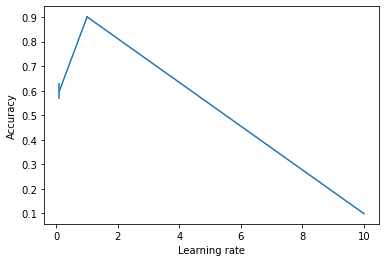

In [70]:
plt.errorbar(learning_list, np.mean(acc_valid, axis=1), np.std(acc_valid, axis=1))
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.show()

In [73]:
learning_list = [2,5,7]

num_folds = 3
acc_valid = np.zeros((len(learning_list), num_folds))
for i, learning in enumerate(learning_list):
    #Find the validation accuracy for num_folds splits for a given learning rate
    for f, (tr, val) in enumerate(cross_validate(x_train.shape[0], num_folds)):
        model = MLP_relu_one()
        optimizer = GradientDescent(learning_rate=learning,iters=20000)
        model.fit(x_train[tr], y_train[tr], x_test, y_test, optimizer)
        acc_valid[i, f] = evaluate_acc(y_train[val], model.predict(x_train[val]))
        print('For learning rate =',learning,'and fold',f,'the accuracy is:',acc_valid[i, f])
# Given the time needed to perform cross-validation, we stopped the algorithm when we saw that 5 was not giving a good accuracy

For learning rate = 2 and fold 0 the accuracy is: 0.91935
For learning rate = 2 and fold 1 the accuracy is: 0.9175
For learning rate = 2 and fold 2 the accuracy is: 0.9201
For learning rate = 5 and fold 0 the accuracy is: 0.0997


KeyboardInterrupt: 

In [74]:
learning_list = [3,4]

num_folds = 3
acc_valid = np.zeros((len(learning_list), num_folds))
for i, learning in enumerate(learning_list):
    #Find the validation accuracy for num_folds splits for a given learning rate
    for f, (tr, val) in enumerate(cross_validate(x_train.shape[0], num_folds)):
        model = MLP_relu_one()
        optimizer = GradientDescent(learning_rate=learning,iters=20000)
        model.fit(x_train[tr], y_train[tr], x_test, y_test, optimizer)
        acc_valid[i, f] = evaluate_acc(y_train[val], model.predict(x_train[val]))
        print('For learning rate =',learning,'and fold',f,'the accuracy is:',acc_valid[i, f])

For learning rate = 3 and fold 0 the accuracy is: 0.9333
For learning rate = 3 and fold 1 the accuracy is: 0.9248
For learning rate = 3 and fold 2 the accuracy is: 0.9316
For learning rate = 4 and fold 0 the accuracy is: 0.09965
For learning rate = 4 and fold 1 the accuracy is: 0.93665
For learning rate = 4 and fold 2 the accuracy is: 0.9396


In [75]:
model = MLP_relu_one()
optimizer = GradientDescent(learning_rate=4, iters=20000, epochs=100)

model.fit(x_train, y_train, x_test, y_test, optimizer)
acc = evaluate_acc(y_test, model.predict(x_test))
print(f'The accuracy is {acc*100:.1f}.')

The accuracy is 93.3.


In [17]:
model = MLP_relu_one(cost=True)
optimizer = GradientDescent(learning_rate=4, epochs=50, iters=600, cost=True)

model.fit(x_train, y_train, x_test, y_test, optimizer)

Epoch: 1, Train error: 2.3029, Test error: 2.3028
Epoch: 2, Train error: 2.1097, Test error: 2.1228
Epoch: 3, Train error: 1.1792, Test error: 1.2341
Epoch: 4, Train error: 0.8282, Test error: 0.7461
Epoch: 5, Train error: 0.5690, Test error: 0.5708
Epoch: 6, Train error: 0.5567, Test error: 0.4849
Epoch: 7, Train error: 0.4895, Test error: 0.4343
Epoch: 8, Train error: 0.5135, Test error: 0.3997
Epoch: 9, Train error: 0.3069, Test error: 0.3778
Epoch: 10, Train error: 0.3187, Test error: 0.3605
Epoch: 11, Train error: 0.4867, Test error: 0.3472
Epoch: 12, Train error: 0.4612, Test error: 0.3353
Epoch: 13, Train error: 0.3037, Test error: 0.3259
Epoch: 14, Train error: 0.2912, Test error: 0.3185
Epoch: 15, Train error: 0.5194, Test error: 0.3118
Epoch: 16, Train error: 0.4190, Test error: 0.3050
Epoch: 17, Train error: 0.3146, Test error: 0.2991
Epoch: 18, Train error: 0.2952, Test error: 0.2941
Epoch: 19, Train error: 0.2993, Test error: 0.2887
Epoch: 20, Train error: 0.2658, Test err

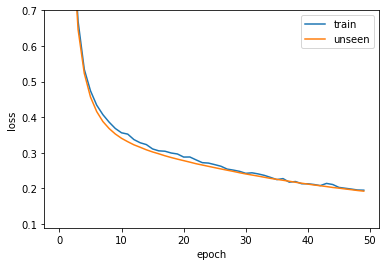

In [20]:
plt.plot(np.arange(len(model.train_loss)), model.train_loss, '-', label='train')
plt.plot(np.arange(len(model.test_loss)), model.test_loss, '-', label='unseen')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(top = 0.7)
plt.savefig('epochs_1layer.png')
plt.show()